# Immo Eliza — Predicting Real Estate Prices 
**Author:** Hamideh Baggali  
**Task:** Regression model to predict log(price) using cleaned Immo Eliza dataset.  
**Date:** 28/11/25-one-week project


This notebook builds and evaluates regression models to predict real estate prices (log-price) in Belgium.
I use a cleaned dataset (`data_main_cleaned.csv`) and test three models: Linear Regression, Decision Tree, and XGBoost.
Focus: reproducible preprocessing pipeline, simple feature set, model comparison, and final model saving.


### Environment & imports

In [1]:
# Basic imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Show versions (short)
import sklearn, xgboost
print("pandas", pd.__version__, "scikit-learn", sklearn.__version__, "xgboost", xgboost.__version__)


pandas 2.3.3 scikit-learn 1.7.2 xgboost 3.1.2



### Data load

In [24]:
df = pd.read_csv("data_main_cleaned.csv")
print("Rows, cols:", df.shape)
print(df.columns)
df.head()



Rows, cols: (12462, 18)
Index(['build_year', 'facades', 'garden', 'living_area', 'locality_name',
       'number_rooms', 'postal_code', 'price', 'property_id', 'property_type',
       'property_url', 'state', 'swimming_pool', 'terrace', 'province',
       'property_type_name', 'state_mapped', 'price_log'],
      dtype='object')


,build_year,facades,garden,living_area,locality_name,number_rooms,postal_code,price,property_id,property_type,property_url,state,swimming_pool,terrace,province,property_type_name,state_mapped,price_log
0,1996.0,2.0,1,270.0,Strombeek-Bever,4.0,1853.0,580000.0,vba56897,Residence,https://immovlan.be/en/detail/residence/for-sa...,Excellent,0,1.0,Flemish Brabant,house,ready_to_move_in,13.270785
1,1991.0,4.0,1,218.0,Céroux-Mousty,5.0,1341.0,695000.0,vbd16452,Residence,https://immovlan.be/en/detail/residence/for-sa...,Excellent,1,1.0,Walloon Brabant,house,ready_to_move_in,13.451669
2,1970.0,4.0,0,135.0,Limal,3.0,1300.0,249000.0,vbd12380,Apartment,https://immovlan.be/en/detail/apartment/for-sa...,To be renovated,0,1.0,Walloon Brabant,apartment,to_renovate,12.425212
3,1959.0,3.0,1,176.0,Strombeek-Bever,3.0,1853.0,499000.0,vbd39990,Residence,https://immovlan.be/en/detail/residence/for-sa...,Normal,0,1.0,Flemish Brabant,house,ready_to_move_in,13.120363
4,2007.0,4.0,1,200.0,Céroux-Mousty,4.0,1341.0,650000.0,vbd24791,Residence,https://immovlan.be/en/detail/residence/for-sa...,Excellent,0,1.0,Walloon Brabant,house,ready_to_move_in,13.384729


### Short EDA

number_rooms             0
living_area              0
price                    0
price_log                0
property_type_name       0
state_mapped          2527
postal_code              0
dtype: int64


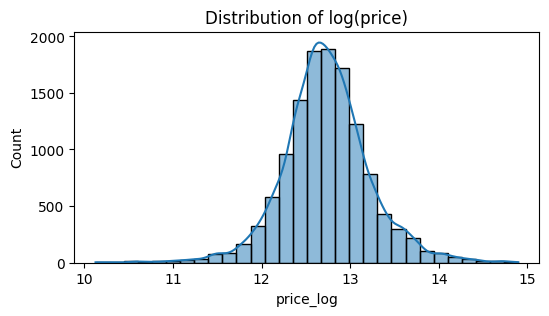

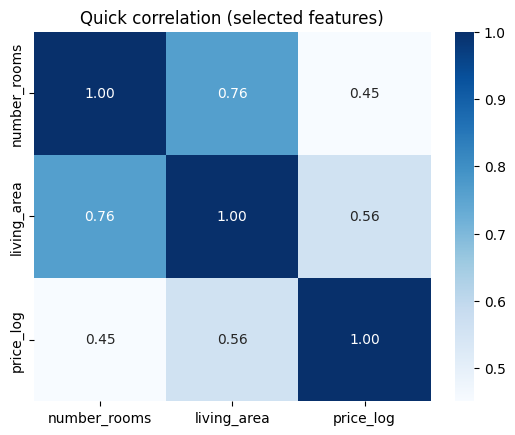

In [21]:
# Missing values (selected columns)
cols = ['number_rooms','living_area','price','price_log','property_type_name','state_mapped','postal_code']
print(df[cols].isna().sum())

# Target distribution
plt.figure(figsize=(6,3))
sns.histplot(df['price_log'], bins=30, kde=True)
plt.title("Distribution of log(price)")
plt.show()

# Small correlation heatmap with features you'll use
corr_cols = ['number_rooms', 'living_area', 'price_log']
sns.heatmap(df[corr_cols].corr(), annot=True, fmt=".2f", cmap="Blues")
plt.title("Quick correlation (selected features)")
plt.show()


### Inspect_column ( a function)

In [ ]:
### function for checking columns
import pandas as pd

def inspect_column(df, col_name):
    """
    Inspect a column in a DataFrame.
    Shows data type, missing values, unique values, value counts,
    and numeric descriptive statistics if applicable.
    """
    if col_name not in df.columns:
        print(f"Column '{col_name}' does not exist in DataFrame.")
        return
    
    col = df[col_name]
    print(f"--- Inspecting column: {col_name} ---\n")
    
    print("Data type:", col.dtype)
    print("Missing values:", col.isna().sum())
    
    if col.dtype in ['int64', 'float64']:
        print("\nDescriptive statistics:")
        print(col.describe())
        print("\nAny negative values?", (col < 0).sum())
    
    print("\nNumber of unique values:", col.nunique())
    print("Unique values (up to 20):", col.unique()[:20])
    
    print("\nValue counts (top 20):")
    print(col.value_counts(dropna=False).head(20))
    print("\n" + "-"*40 + "\n")
    

# Example usage
""" the column to inspect for the model include
['number_rooms', 'living_area', 'property_house', 'state_ready', 'postal_code_target']
"""
df = pd.read_csv("data_main_cleaned.csv")
inspect_column(df, 'postal_code')



price_log is moderately skewed; correlations are modest.

### Preprocessing

In [4]:
# Copy to avoid SettingWithCopyWarning
df_proc = df.copy()

# 1) Remove noisy category
df_proc = df_proc[df_proc['property_type_name'] != 'exceptional'].copy()

# 2) Binary encode property type (house vs apartment)
df_proc['property_house'] = (df_proc['property_type_name'] == 'house').astype(int)

# 3) Fill state_mapped NaNs and binary encode
df_proc['state_mapped'] = df_proc['state_mapped'].fillna('ready_to_move_in')
df_proc['state_ready'] = (df_proc['state_mapped'] == 'ready_to_move_in').astype(int)

# 4) Postal code -> target encoding (mean log-price per postal code)
df_proc['postal_code'] = df_proc['postal_code'].astype(str)
postal_mean = df_proc.groupby('postal_code')['price_log'].mean()
df_proc['postal_code_target'] = df_proc['postal_code'].map(postal_mean)

# 5) Ensure numeric columns are numeric and drop rows with any remaining NaNs in features/target
features = ['number_rooms','living_area','property_house','state_ready','postal_code_target']
df_proc[features] = df_proc[features].apply(pd.to_numeric, errors='coerce')
df_proc = df_proc.dropna(subset=features + ['price_log']).reset_index(drop=True)

print("After preprocessing:", df_proc.shape)
df_proc[features + ['price_log']].describe().round(3)


After preprocessing: (11717, 21)


,number_rooms,living_area,property_house,state_ready,postal_code_target,price_log
count,11717.000,11717.000,11717.000,11717.000,11717.000,11717.000
mean,2.627,136.694,0.448,0.892,12.714,12.714
std,1.103,67.669,0.497,0.310,0.297,0.464
min,1.000,24.000,0.000,0.000,10.970,10.127
25%,2.000,90.000,0.000,1.000,12.557,12.429
50%,3.000,120.000,0.000,1.000,12.710,12.704
75%,3.000,168.000,1.000,1.000,12.846,12.972
max,10.000,500.000,1.000,1.000,14.058,14.790


All preprocessing steps are deterministic and saved in df_proc. We will split from df_proc.

### Train / Validation / Test split

In [5]:
X = df_proc[features]
y = df_proc['price_log']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE)

# Optional: save splits
train = X_train.join(y_train)
val = X_val.join(y_val)
test = X_test.join(y_test)
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

print("Train/Val/Test sizes:", train.shape, val.shape, test.shape)


Train/Val/Test sizes: (7030, 6) (2343, 6) (2344, 6)


60/20/20 split-Saved splits for reproducibility.

### Modeling — train & evaluate helper

In [6]:
def evaluate_model(model, X_tr, y_tr, X_v, y_v, name="model"):
    model.fit(X_tr, y_tr)
    y_pred_val = model.predict(X_v)
    y_pred_train = model.predict(X_tr)
    results = {
        'train_mse': mean_squared_error(y_tr, y_pred_train),
        'val_mse': mean_squared_error(y_v, y_pred_val),
        'train_mae': mean_absolute_error(y_tr, y_pred_train),
        'val_mae': mean_absolute_error(y_v, y_pred_val),
        'train_r2': r2_score(y_tr, y_pred_train),
        'val_r2': r2_score(y_v, y_pred_val)
    }
    print(f"\n{name} results:")
    for k,v in results.items():
        print(f"{k}: {v:.4f}")
    return model, results


Create a small helper function to train and evaluate a model so we can reuse it for all models.

### Model 1 — Linear Regression

In [7]:
lr = LinearRegression()
lr, res_lr = evaluate_model(lr, X_train, y_train, X_val, y_val, name="Linear Regression")



Linear Regression results:
train_mse: 0.0746
val_mse: 0.0748
train_mae: 0.1979
val_mae: 0.2014
train_r2: 0.6567
val_r2: 0.6511


Linear regression baseline — interpretable coefficients.

### coefficients

In [8]:
coef = pd.Series(lr.coef_, index=features)
print(coef.round(4))
print("Intercept:", lr.intercept_.round(4))


number_rooms          0.0728
living_area           0.0029
property_house       -0.1568
state_ready           0.3208
postal_code_target    0.8186
dtype: float64
Intercept: 1.5034


### Model 2 — Decision Tree

In [9]:
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt, res_dt = evaluate_model(dt, X_train, y_train, X_val, y_val, name="Decision Tree")



Decision Tree results:
train_mse: 0.0019
val_mse: 0.1169
train_mae: 0.0132
val_mae: 0.2177
train_r2: 0.9913
val_r2: 0.4551


Decision Tree likely to overfit; hyperparameters can be tuned.

### Model 3 — XGBoost (regularised)

In [10]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    random_state=RANDOM_STATE,
    verbosity=0
)
xgb, res_xgb = evaluate_model(xgb, X_train, y_train, X_val, y_val, name="XGBoost")



XGBoost results:
train_mse: 0.0567
val_mse: 0.0647
train_mae: 0.1706
val_mae: 0.1827
train_r2: 0.7392
val_r2: 0.6982


Final chosen model: XGBoost with reduced overfitting.

### Feature importance for the XGBoost model

Feature importance:

              feature  importance
4  postal_code_target    0.298199
3         state_ready    0.269884
1         living_area    0.228458
2      property_house    0.107363
0        number_rooms    0.096096


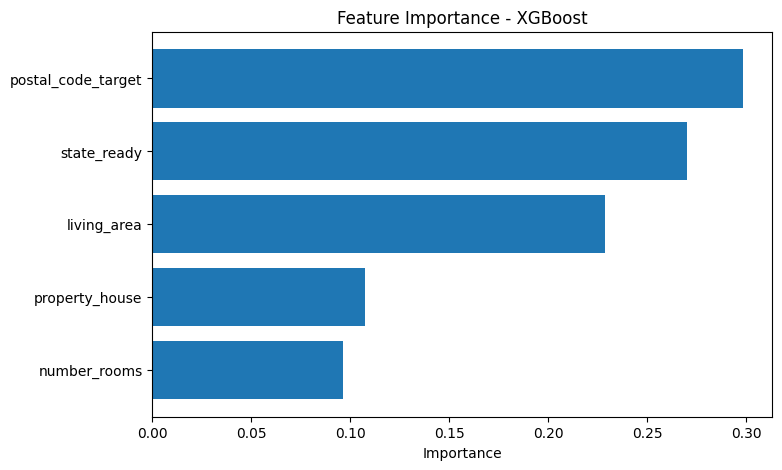

In [14]:
# 1. Create a DataFrame with feature importance
import pandas as pd
import matplotlib.pyplot as plt

feat_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False)

# 2. Show the table
print("Feature importance:\n")
print(feat_importance)

# 3. Plot feature importance
plt.figure(figsize=(8,5))
plt.barh(feat_importance['feature'], feat_importance['importance'])
plt.gca().invert_yaxis()  # puts the most important feature on top
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.show()


### Correlation heatmap

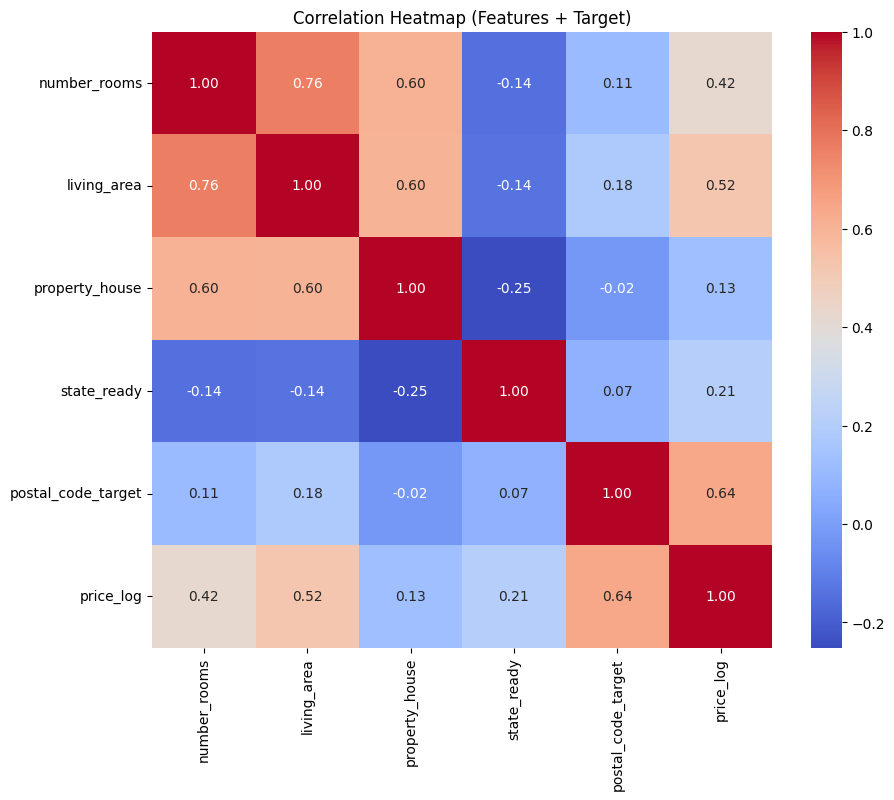

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select features you care about (same as used in model)
corr_cols = X_train.columns.tolist() + ['price_log']  # include target
df_corr = pd.concat([X_train, y_train], axis=1)

plt.figure(figsize=(10,8))
sns.heatmap(df_corr[corr_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Features + Target)")
plt.show()


### Compare models

In [11]:
import pandas as pd
comparison = pd.DataFrame({
    'Linear': res_lr,
    'DecisionTree': res_dt,
    'XGBoost': res_xgb
}).T[['train_mse','val_mse','train_r2','val_r2','train_mae','val_mae']]
comparison.round(4)


,train_mse,val_mse,train_r2,val_r2,train_mae,val_mae
Linear,0.0746,0.0748,0.6567,0.6511,0.1979,0.2014
DecisionTree,0.0019,0.1169,0.9913,0.4551,0.0132,0.2177
XGBoost,0.0567,0.0647,0.7392,0.6982,0.1706,0.1827


### To save final model

In [12]:
best_model = xgb  # choose whichever you prefer
joblib.dump(best_model, "best_model_xgb.pkl")
print("Saved best model to best_model_xgb.pkl")


Saved best model to best_model_xgb.pkl


### Predict.py example

In [13]:
# Example single-row prediction (inverse transform log to price)
sample = X_test.iloc[0:1].copy()
pred_log = best_model.predict(sample)[0]
pred_price = np.expm1(pred_log)
print("Predicted price:", round(pred_price, 0))


Predicted price: 343886.0
